# Methodology for determining if two time series are cointegrated.

Cointegrated time series are stationary, meaning that deviations in their spread will eventually return to zero over time (linear combination of the two series is integrated of order zero). Cointegrated time series can be easily exploited in a mean reversion strategy in which trades are signaled by abnormal deviations in the spread of the two securities.

Note:
- Cointegration on a backtest does not always mean thhat the cointegration will continue into the future
- Be careful of overtrading spread deviations so as to optimize the tradeoff between opportunity and transaction fees
- Spreads are calculated using the hedge ratio between the two securities, which is essentially the number of shares of security two you need to purchase against the first security.

In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS

     |████████████████████████████████| 96 kB 2.9 MB/s eta 0:00:011


In [4]:
# read data
gld_df = pd.read_excel('GLD.xls')
gdx_df = pd.read_excel('GDX.xls')

In [5]:
df = pd.merge(gld_df, gdx_df, on='Date', suffixes=('_GLD', '_GDX'))
df.head()

,Date,Open_GLD,High_GLD,Low_GLD,Close_GLD,Volume_GLD,Adj Close_GLD,Open_GDX,High_GDX,Low_GDX,Close_GDX,Volume_GDX,Adj Close_GDX
0,2007-11-30,78.35,78.60,76.98,77.32,9509100,77.32,47.09,47.50,45.70,46.36,2006000,46.36
1,2007-11-29,79.28,79.33,78.28,78.28,9306700,78.28,47.10,48.00,46.76,47.02,1668500,47.02
2,2007-11-28,79.42,79.87,78.76,79.57,9706700,79.57,46.11,48.00,46.06,47.86,3893200,47.86
3,2007-11-27,80.70,80.89,79.81,80.10,7229900,80.10,46.84,46.84,45.74,46.61,2329700,46.61
4,2007-11-26,82.25,82.25,81.13,81.30,7440200,81.30,49.43,49.43,46.85,47.06,1966500,47.06


In [6]:
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head()

,Open_GLD,High_GLD,Low_GLD,Close_GLD,Volume_GLD,Adj Close_GLD,Open_GDX,High_GDX,Low_GDX,Close_GDX,Volume_GDX,Adj Close_GDX
Date,,,,,,,,,,,,
2006-05-23,65.99,67.16,65.91,66.38,10509700,66.38,37.75,39.22,37.75,37.96,620900,37.85
2006-05-24,64.83,65.16,63.22,64.06,11065600,64.06,37.13,37.57,35.87,36.52,638600,36.41
2006-05-25,64.12,64.76,63.76,64.70,6505400,64.70,37.18,38.32,36.98,38.32,367000,38.21
2006-05-26,65.01,65.10,63.75,65.10,5265900,65.10,38.74,38.74,37.77,38.55,269400,38.44
2006-05-30,65.20,66.24,65.00,65.11,8240200,65.11,39.50,39.72,38.11,38.17,559100,38.06


In [8]:
print(f'Number of days in dataset: {len(df)}')

Number of days in dataset: 385


In [9]:
trainset = np.arange(0, 252)
df = df.iloc[trainset, :]  # use only first year of data for training

Using the Engle-Granger test for cointegration testing

In [11]:
# coint_t: Cointegration test statistic (t-statistic) for the null hypothesis that the two series are not cointegrated.
# pvalue: MacKinnon's approximate p-value
# crit_value: Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
coint_t, pvalue, crit_value = coint(
    df['Adj Close_GLD'], df['Adj Close_GDX']
    )
print(f'cointegration test statistic: {coint_t}')
print(f'p-value: {pvalue}')
print(f'critical values: {crit_value}')

cointegration test statistic: -2.3591268376687173
p-value: 0.344449488042792
critical values: [-3.94060523 -3.36058133 -3.06139039]


Since the absolute value of the t-stat (2.4) is less than the absolute value of the critical value @ 90%, the two series are not cointegrated.

In [12]:
# Determine the hedge ratio
model = OLS(df['Adj Close_GLD'], df['Adj Close_GDX'])
results = model.fit()
hedge_ratio = results.params[0]
print(f'hedge ratio: {hedge_ratio}')

hedge ratio: 1.6310089532247043


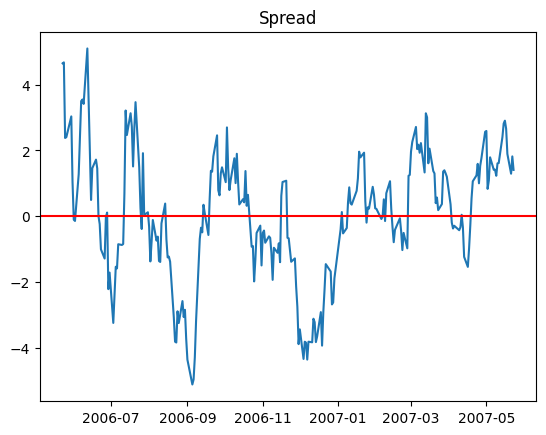

In [14]:
# spread = GLD - hedge_ratio * GDX
spread = df['Adj Close_GLD'] - hedge_ratio * df['Adj Close_GDX']
plt.plot(spread)
plt.title('Spread')
plt.axhline(0, color='red')
plt.show()